In [1]:
# Import Libraries that are used to solve this task
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, log_loss

In [2]:
# Store the path of dataset by category
DATADIR = "/kaggle/input/cat-dog/PetImages"
CATEGORIES = ["Cat", "Dog"]
IMG_SIZE = 64  # Resize all images to 100x100 for performance


In [3]:
# Load and Preprocess Data
def load_data():
    data = []
    labels = []
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in tqdm(os.listdir(path), desc=f"Loading {category} images"):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append(resized_array.flatten())  # Flatten 2D image to 1D vector
                labels.append(class_num)
            except Exception as e:
                pass
    return np.array(data), np.array(labels)

X, y = load_data()


Loading Dog images: 100%|██████████| 12499/12499 [02:25<00:00, 85.87it/s]


In [4]:
# Split Dataset
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
) 

In [5]:
# Train SVM Model

# Using a pipeline: StandardScaler helps SVM converge faster and improves performance.
linear_svm = make_pipeline(StandardScaler(), LinearSVC(max_iter=20000, dual=False))

print(" Training Linear SVM model...")
linear_svm.fit(X_train, y_train)


 Training Linear SVM model...


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(dual=False, max_iter=20000))])

In [6]:
# Predictions
y_train_pred = linear_svm.predict(X_train)
y_val_pred = linear_svm.predict(X_val)

# Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

print(f"\n📈 Training Accuracy: {train_acc:.4f}")
print(f"📉 Validation Accuracy: {val_acc:.4f}")



📈 Training Accuracy: 0.7225
📉 Validation Accuracy: 0.5204


In [7]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=CATEGORIES))




Classification Report:
              precision    recall  f1-score   support

         Cat       0.52      0.54      0.53      3743
         Dog       0.52      0.50      0.51      3741

    accuracy                           0.52      7484
   macro avg       0.52      0.52      0.52      7484
weighted avg       0.52      0.52      0.52      7484



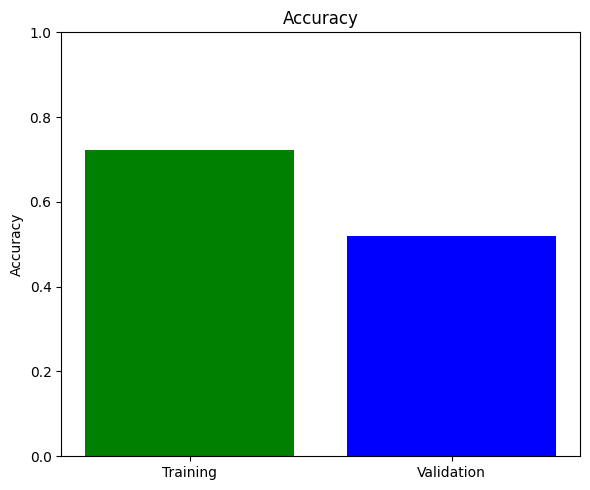

In [8]:
import matplotlib.pyplot as plt

# Metrics
metrics = ['Training', 'Validation']
accuracy = [train_acc, val_acc]

plt.figure(figsize=(6, 5))
plt.bar(metrics, accuracy, color=['green', 'blue'])
plt.title('Accuracy')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()


In [9]:

# Create and calibrate the SGDClassifier (acts like linear SVM with probabilities)
base_clf = SGDClassifier(loss='hinge', max_iter=1000, random_state=42)
svm_model = CalibratedClassifierCV(estimator=base_clf, cv=3)

# Train model
print("Training calibrated linear SVM...")
svm_model.fit(X_train, y_train)

# Accuracy
train_acc = accuracy_score(y_train, svm_model.predict(X_train))
val_acc = accuracy_score(y_val, svm_model.predict(X_val))

# Log Loss
train_loss = log_loss(y_train, svm_model.predict_proba(X_train))
val_loss = log_loss(y_val, svm_model.predict_proba(X_val))

# Print results
print(f"\n📈 Training Accuracy: {train_acc:.4f}")
print(f"📉 Validation Accuracy: {val_acc:.4f}")
print(f"🧮 Training Log Loss: {train_loss:.4f}")
print(f"🧮 Validation Log Loss: {val_loss:.4f}")


Training calibrated linear SVM...

📈 Training Accuracy: 0.5001
📉 Validation Accuracy: 0.5001
🧮 Training Log Loss: 0.6931
🧮 Validation Log Loss: 0.6931


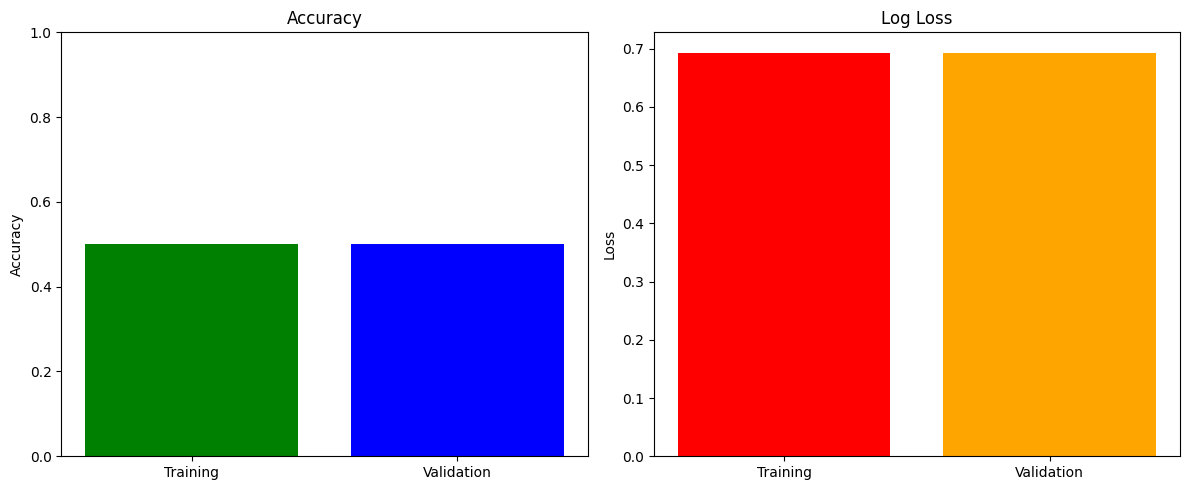

In [10]:
# Plot both accuracy and log loss
metrics = ['Training', 'Validation']
accuracy = [train_acc, val_acc]
loss = [train_loss, val_loss]

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.bar(metrics, accuracy, color=['green', 'blue'])
plt.title('Accuracy')
plt.ylim(0, 1)
plt.ylabel('Accuracy')

# Log Loss
plt.subplot(1, 2, 2)
plt.bar(metrics, loss, color=['red', 'orange'])
plt.title('Log Loss')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()
